In [18]:
import os
import shutil
import random
import time
import requests
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from bs4 import BeautifulSoup
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

IMG_SIZE = (150, 150)
BATCH_SIZE = 32
DATASET_DIR = "dataset"
BRAND_NAME = "lexus"

In [17]:
import os
import zipfile
import shutil
from google.colab import files

# 1. Підготовка робочої папки
DATASET_DIR = "dataset"
if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)
os.makedirs(DATASET_DIR)

print("Щоб завантажити дані, потрібен файл kaggle.json.")
print("Завантажте його зараз у вікні нижче:")

uploaded = files.upload()

if len(uploaded) > 0:
    filename = list(uploaded.keys())[0]
    print(f"\nОтримано файл ключа: {filename}")

    kaggle_dir = '/root/.kaggle'
    os.makedirs(kaggle_dir, exist_ok=True)
    dest_path = os.path.join(kaggle_dir, 'kaggle.json')
    shutil.move(filename, dest_path)
    os.chmod(dest_path, 600)

    !kaggle datasets download -d kovalkostiantyn/data-lab6 --force

    zip_path = "data-lab6.zip"

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("temp_extract")

        found_data = False
        for root, dirs, files_list in os.walk("temp_extract"):
            if "logo" in dirs and "background" in dirs:

                shutil.move(os.path.join(root, "logo"), os.path.join(DATASET_DIR, "positive"))
                shutil.move(os.path.join(root, "background"), os.path.join(DATASET_DIR, "negative"))

                found_data = True
                break

        if os.path.exists("temp_extract"):
            shutil.rmtree("temp_extract")
        os.remove(zip_path)

        if found_data:
            num_pos = len(os.listdir(os.path.join(DATASET_DIR, 'positive')))
            num_neg = len(os.listdir(os.path.join(DATASET_DIR, 'negative')))
            print(f"\nДатасет завантажено!")
        else:
            print("Папки 'logo' та 'background' не знайдено в архіві.")
    else:
        print("Не вдалося завантажити архів.")
else:
    print("Файл kaggle.json не завантажено.")

Щоб завантажити дані, потрібен файл kaggle.json.
Завантажте його зараз у вікні нижче:


Saving kaggle.json to kaggle.json

Отримано файл ключа: kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kovalkostiantyn/data-lab6
License(s): apache-2.0
 70% 135M/193M [00:00<00:00, 1.40GB/s]
100% 193M/193M [00:01<00:00, 198MB/s] 

Датасет завантажено!


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

print("Створення генераторів...")
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Створення генераторів...
Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [6]:
def build_custom_xception(input_shape=(150, 150, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Entry Flow
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Block 1
    residual = layers.Conv2D(64, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.add([x, residual])

    # Block 2
    residual = layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.add([x, residual]) #

    # Middle Flow
    for _ in range(4):
        residual = x
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([x, residual])

    # Exit Flow
    residual = layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.add([x, residual])

    x = layers.SeparableConv2D(512, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # Вихідний шар
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = layers.Dense(num_classes, activation=activation)(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Custom_Xception")
    return model

model = build_custom_xception(input_shape=IMG_SIZE + (3,))
model.summary()

Model: "Custom_Xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 150, 150,  │      2,336 │ activation[0][0]  │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │      2,048 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 75, 75,    │      8,768 │ add[0][0]         │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │      8,192 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 38, 38,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        512 │ conv2d_2[0][0]  

 Total params: 300,737 (1.15 MB)

 Trainable params: 296,833 (1.13 MB)

 Non-trainable params: 3,904 (15.25 KB)

Початок навчання...
Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8453 - loss: 0.3062 - val_accuracy: 0.5000 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 903ms/step - accuracy: 0.9128 - loss: 0.2423 - val_accuracy: 0.5000 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - accuracy: 0.9291 - loss: 0.2010 - val_accuracy: 0.5000 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8919 - loss: 0.2432
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 904ms/step - accuracy: 0.8922 - loss: 0.2439 - val_accuracy: 0.5000 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 877ms/step - accuracy: 0.9040 - loss: 0.2501 - val_accuracy: 0.5000 - val_loss: 0.7107 - learning_rate: 5.0000e-04
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 930ms/step - accuracy

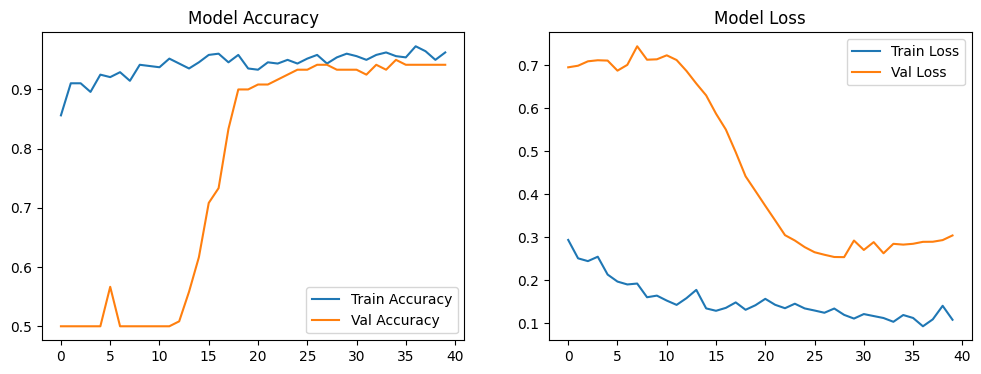

In [11]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("Початок навчання...")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

# Графіки навчання
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

Оцінка на валідаційних даних...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step
Confusion Matrix:


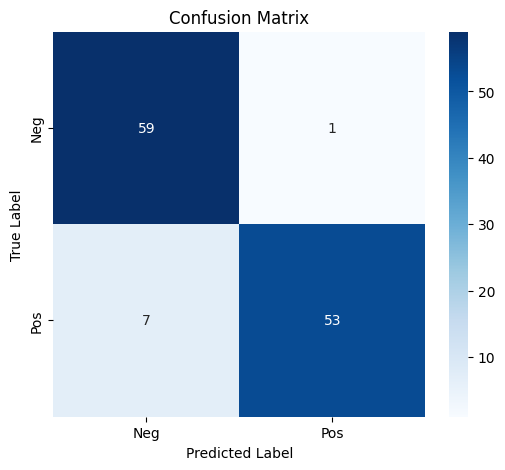

In [16]:
print("Оцінка на валідаційних даних...")
# Отримуємо передбачення
val_generator.reset()
preds = model.predict(val_generator)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = val_generator.classes

# Матриця помилок
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")

# Візуалізація матриці
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Будь ласка, завантажте файл відео для тестування:


Saving test_video.mp4 to test_video (3).mp4

Відео 'test_video (3).mp4' успішно завантажено.
Обробка відео: test_video (3).mp4
Запуск по-кадрової обробки...
Час Single Frame: 257.31 сек
Запуск пакетної обробки (Batch)...
Час Batch Processing: 22.27 сек

Прискорення: 11.55x


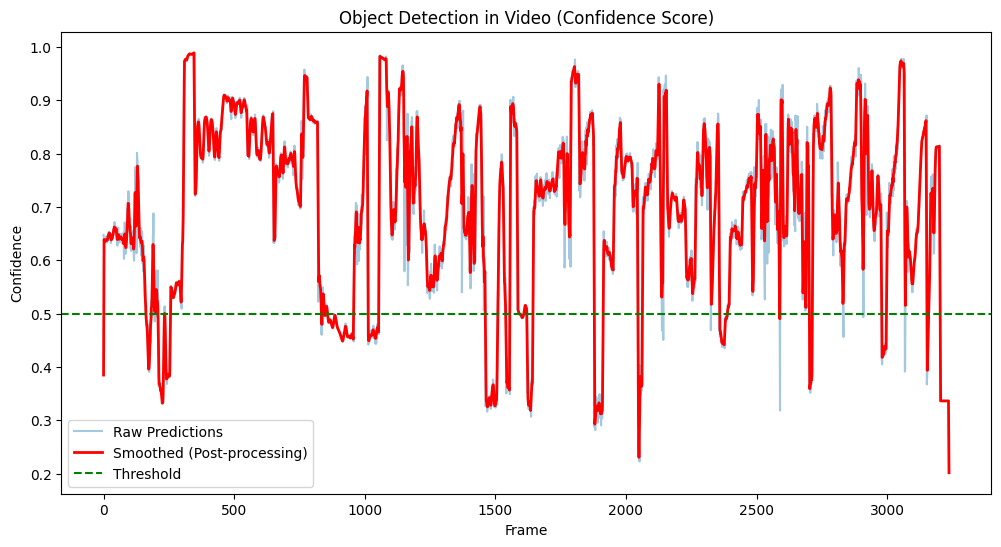

In [20]:
print("Будь ласка, завантажте файл відео для тестування:")
uploaded = files.upload()

if uploaded:
    VIDEO_PATH = list(uploaded.keys())[0]
    print(f"\nВідео '{VIDEO_PATH}' успішно завантажено.")
else:
    print("\nФайл не завантажено. Буде використано шлях за замовчуванням (якщо він існує).")

def smooth_predictions(predictions, window_size=5):
    return np.convolve(predictions, np.ones(window_size)/window_size, mode='same')

if not os.path.exists(VIDEO_PATH):
    print(f"Файл відео '{VIDEO_PATH}' не знайдено! Завантажте відео у Colab.")
else:
    print(f"Обробка відео: {VIDEO_PATH}")

    # 1. По-кадрова обробка (Single Frame)
    print("Запуск по-кадрової обробки...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    start_time = time.time()
    frames_single = []
    preds_single = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        # Попередні обробка
        img = cv2.resize(frame, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = np.expand_dims(img, axis=0) / 255.0

        p = model.predict(img_tensor, verbose=0)[0][0]
        preds_single.append(p)

    cap.release()
    time_single = time.time() - start_time
    print(f"Час Single Frame: {time_single:.2f} сек")


    #2. Пакетна обробка (Batch Processing)
    print("Запуск пакетної обробки (Batch)...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    start_time = time.time()
    batch_frames = []
    preds_batch = []
    frames_buffer = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        img = cv2.resize(frame, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        frames_buffer.append(img)

        if len(frames_buffer) == 32:
            batch_tensor = np.array(frames_buffer)
            batch_preds = model.predict(batch_tensor, verbose=0)
            preds_batch.extend(batch_preds.flatten())
            frames_buffer = []

    # Добробка залишків
    if frames_buffer:
        batch_tensor = np.array(frames_buffer)
        batch_preds = model.predict(batch_tensor, verbose=0)
        preds_batch.extend(batch_preds.flatten())

    cap.release()
    time_batch = time.time() - start_time
    print(f"Час Batch Processing: {time_batch:.2f} сек")

    # Результати
    if time_batch > 0:
        print(f"\nПрискорення: {time_single / time_batch:.2f}x")
    else:
        print("\nПрискорення неможливо обчислити (час виконання занадто малий).")

    smoothed_preds = smooth_predictions(preds_batch)

    # Графік
    plt.figure(figsize=(12, 6))
    plt.plot(preds_batch, label='Raw Predictions', alpha=0.4)
    plt.plot(smoothed_preds, label='Smoothed (Post-processing)', linewidth=2, color='red')
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold')
    plt.title('Object Detection in Video (Confidence Score)')
    plt.xlabel('Frame')
    plt.ylabel('Confidence')
    plt.legend()
    plt.show()
